## Spatial Rainfall in St Louis

First we load our classes and methods from the python scripts in this repo:

In [1]:
from __init__ import *
from rain import *
from common import *

%matplotlib inline
import mpld3 

%load_ext autoreload
%aimport rain
%aimport common

In [3]:
%autoreload

Once our notebook is set up and all our packages are loaded, we can finally load the data. In St Louis, we had access to data from 21 gages from 2000 to 2006 recording at 10 minute intervals, and 101 gages from 2009 to 2014 recording at 15 minute intervals. Each of these sets of rain gages had corresponding radar rainfall data. From 2000 to 2006, the gages only recorded positive data, so there is a possibility that the values are underpredictions of the actual rainfall because a non-functioning gage would show up as a 0 instead of a NaN

In [ ]:
path = './input/'

rg = Rain(path=path, name='StLouis_MSD_gage_{YEAR}.csv', year=range(2009, 2015), ngages=101)
rad = Rain(path=path, name='StLouis_MSD_radar_{YEAR}.csv', year=range(2009, 2015), ngages=101)
rg.ll_file = 'StLouis_MSD_lat_lon_{YEAR}.csv'.format(YEAR=rg.year)
rg.get_ll(cols=['lat','lon'])
rad.ll = rg.ll
p = RadarGage(gage=rg, radar=rad)
p.get_nonan()

rg21 = Rain(path=path, name='StLouis_MSD21_gage_{YEAR}.csv', year=range(2000, 2007), ngages=21, freq='10min', per_hour=6)
rad21 = Rain(path=path, name='StLouis_MSD21_radar_{YEAR}.csv', year=range(2000, 2007), ngages=21, freq='15min', per_hour=4)
rg21.ll_file = 'StLouis_MSD21_lat_lon.csv'
rg21.get_ll(cols=['lat','lon'])
rad21.ll = rg21.ll
rg21.reset_rate('30min')
rad21.reset_rate('30min')
p21 = RadarGage(gage=rg21, radar=rad21)
p21.get_nonan()

In [5]:
p21.save_path = p.save_path = rg.save_path = rad_save_path = rg21.save_path = rad21.save_path = './output/StLouis Summary/'

Once we are satisfied with the temporal aspects we can dive into the spatial aspects of the data

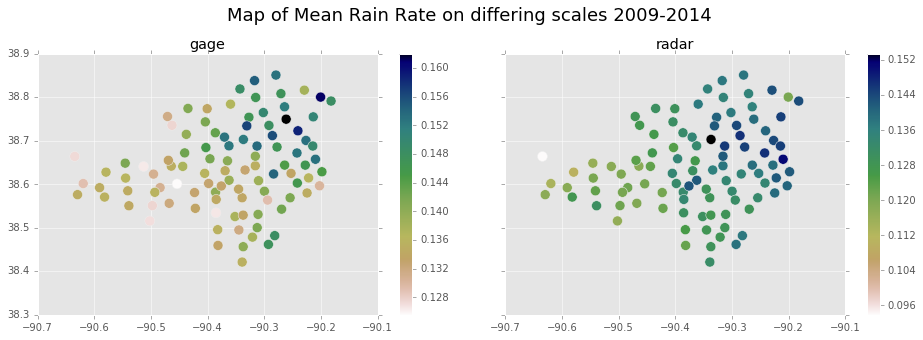

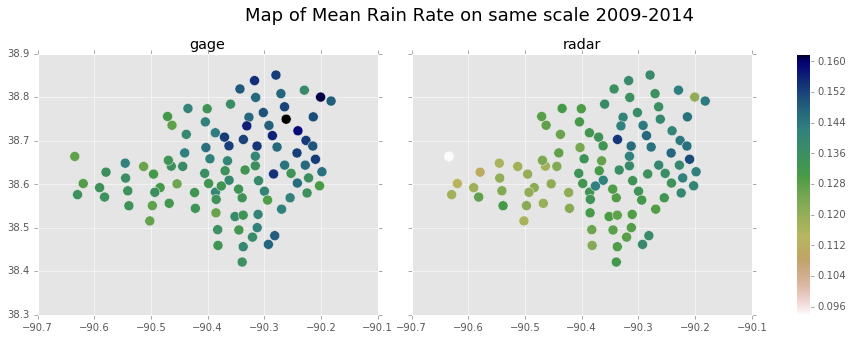

In [6]:
p.plot_rate(gage=p.list_gages(), bar=False, map=True, sharec=False)
p.plot_rate(gage=p.list_gages(), bar=False, map=True, sharec=True)

In [ ]:
for mm in [.253, 1, 5, 25]:
    p.thresh = mm * p.per_hour
    p.plot_prob_wet(time_step='24H', base=12, gage=p.list_gages(), bar=False, map=True, sharec=False)

In [ ]:
for mm in [.253, 1, 5, 25]:
    p.thresh = mm * p.per_hour
    p.plot_prob_wet(time_step='24H', base=12, gage=p.list_gages(), bar=False, map=True, sharec=True)

These maps can offer a lot of insight into potentially interesing trends, but at the end of the day, we probably want to get statistical evidnce of these trends. This is where semivariograms come into play. In order to use R, you first need to run the cell below

In [ ]:
import rpy2.robjects as robjects
from rpy2.robjects import r, pandas2ri

def SVG_storm(storm, target_np=30, alpha=0, tol_hor=90, last_max=False, cressie=False):
    s = {}
    d = {}
    bar = {}
    for i, col in enumerate(storm):
        if col not in ['RG','lat','lon','X','Y']:
            foo = r(('SVG_data = read.table("./SVG_data", sep=",",header = TRUE) \n' +
                    'source("SVG.r") \n'+
                    'iSVG_tab <- get_iSVG(SVG_data, {index},' +
                    'target_np={t}, alpha={a}, tol.hor={h},'+ 
                    'last_max=FALSE, max_bnd=FALSE, cressie=FALSE)\n').format(index=i+1,t=target_np, a=alpha, h=tol_hor))
            df = pd.DataFrame(robjects.numpy2ri.ri2numpy(robjects.globalenv['iSVG_tab']))
            try:
                df.index = df.dist
            except:
                continue
            d.update({col: df})
            pdf = df[:]
            pdf.columns = ['np', 'dist', col, 'dir.hor', 'dir.vert', 'id']
            bar.update({col: pdf[col]})
            s.update({col: (df['gamma'].idxmax(axis=0), df['np'].sum())})
    df = pd.DataFrame(s).transpose()
    plotting_df = pd.DataFrame(bar.values()).transpose()
    df.columns=['dist', 'np']
    return plotting_df, df, d

def plot_SVG(pdf, title = 'Semivariogram of storm'):
    pdf.plot(marker = 'o', figsize=(16,8))
    plt.ylabel('gamma for rate (mm/hr)')
    plt.xlabel('distance between gages in km')
    plt.title(title)

def plot_range(range_df, title='Range distance for storm'):
    range_df = df
    ax = df['dist'].plot(figsize=(16,6), style='o')
    plt.ylabel('distance between gages in km')
    plt.title(title)
    for i, val in enumerate(df['dist']):
        ax.annotate(s = int(df['np'][i]), xy=(df['dist'].index[i], val))

Now you are free to play around with different dates and do some plotting

In [ ]:
p.get_rainiest(5)

In [ ]:
map_rain(p.rainiest, sharec=True)

In [ ]:
rg.get_storm('2011-06-26',time_step='1H')

In [ ]:
pdf, range_df, d = SVG_storm(rg.storm, target_np=30, alpha=39, tol_hor=20)

In [ ]:
plot_SVG(pdf)

If we are interested in examining the spatial correlation of the gages:

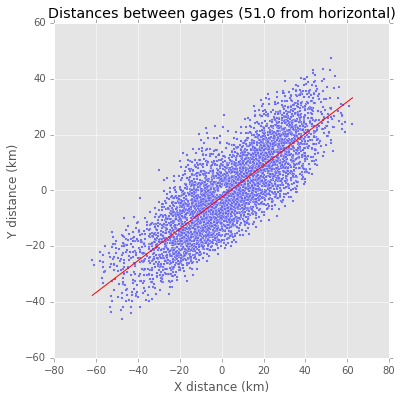

In [7]:
p.plot_ll()

In [8]:
daily = rg.rate.resample('24H', base=12, **get_resample_kwargs(rg.rate))

In [9]:
wet_daily = daily[daily > 0].dropna(how='all')

In [19]:
rg.get_df_corr()

In [20]:
rg.plot_ll()
mpld3.display()

Finding the largest n events of a given year across all the gages can be easily done using the **`get_rainiest`** function

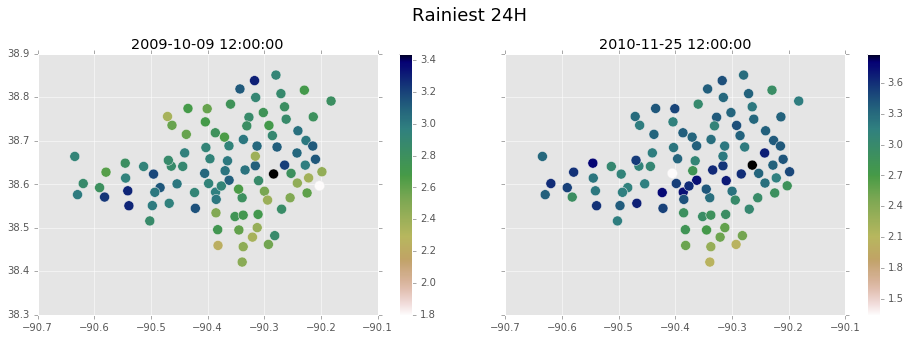

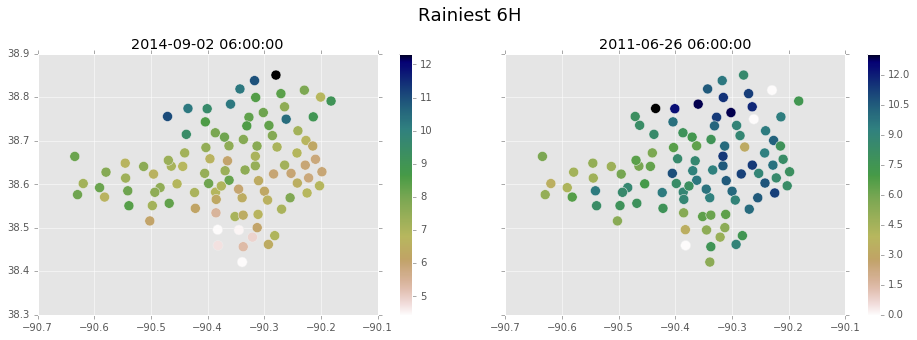

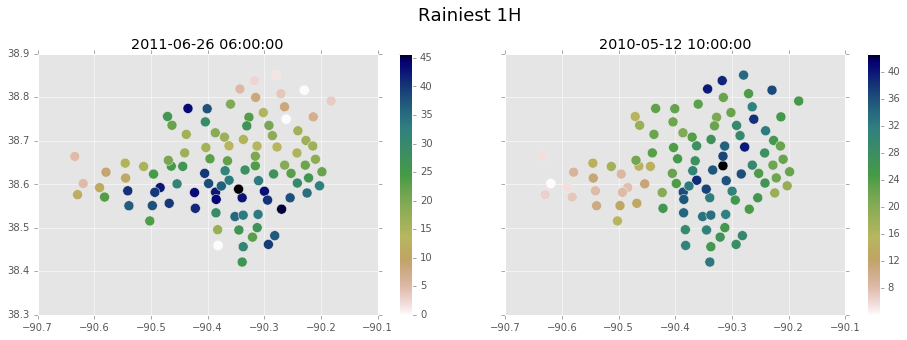

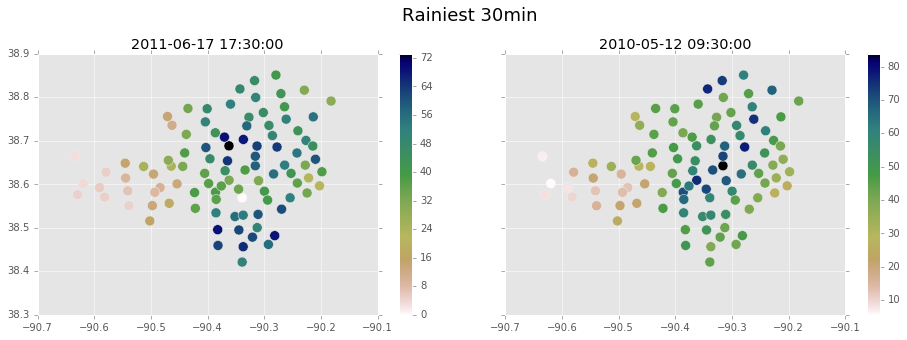

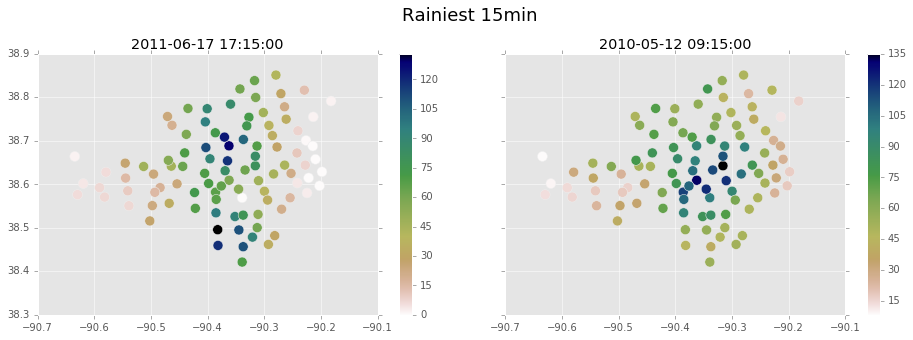

In [30]:
for time_step, base in zip(['24H', '6H','1H','30min', '15min'], [12,0,0,0,0]):
    rg.get_rainiest(2, time_step=time_step, base=base)
    map_rain(rg.rainiest, title='Rainiest '+time_step, save=False)

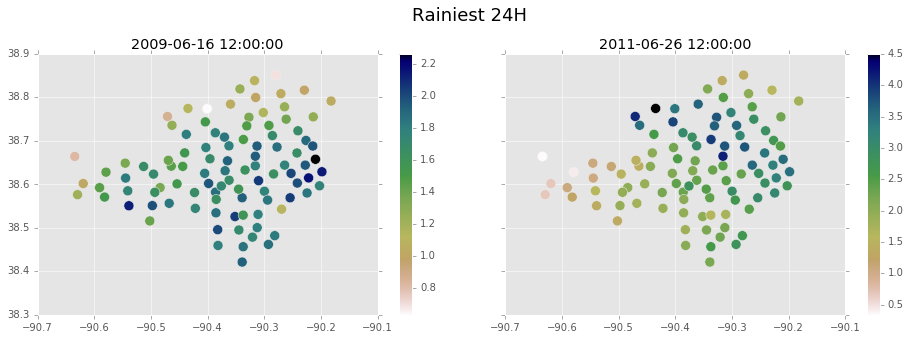

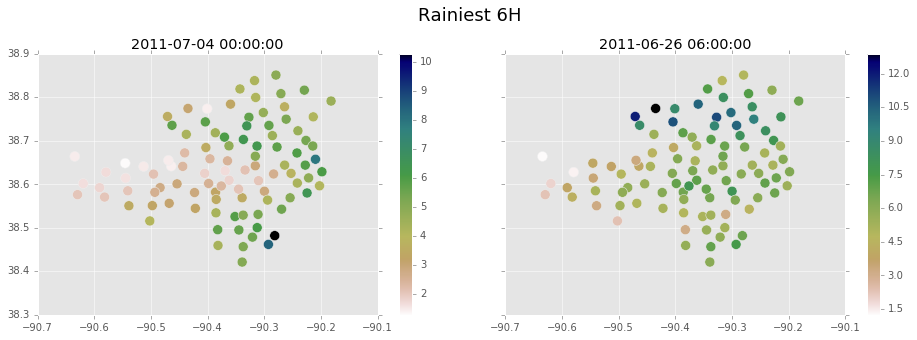

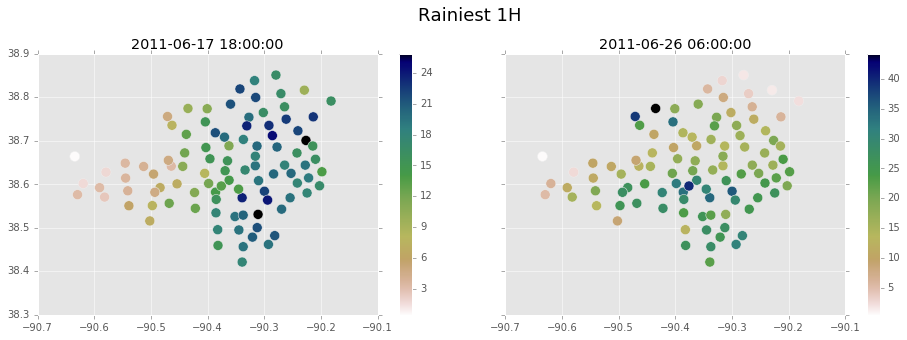

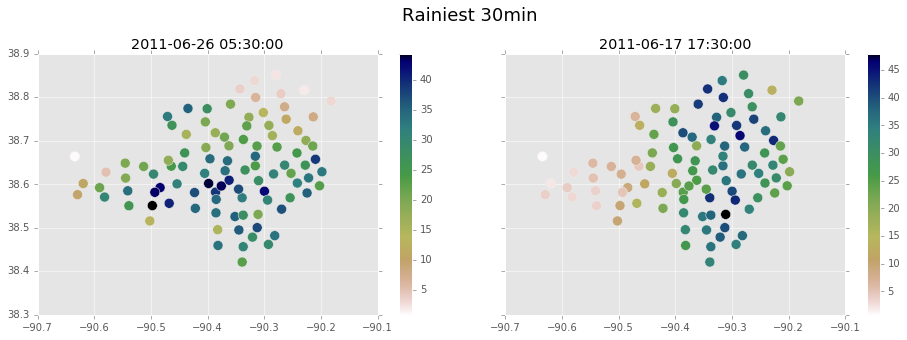

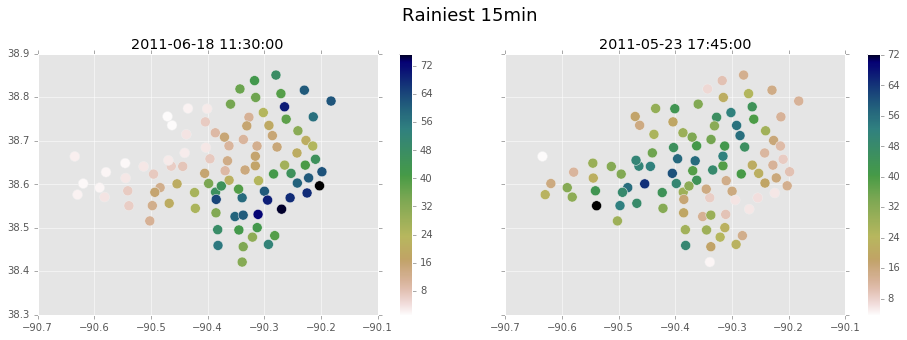

In [32]:
for time_step, base in zip(['24H', '6H','1H','30min', '15min'], [12,0,0,0,0]):
    rad.get_rainiest(2, time_step=time_step, base=base)
    map_rain(rad.rainiest, title='Rainiest '+time_step, save=False)

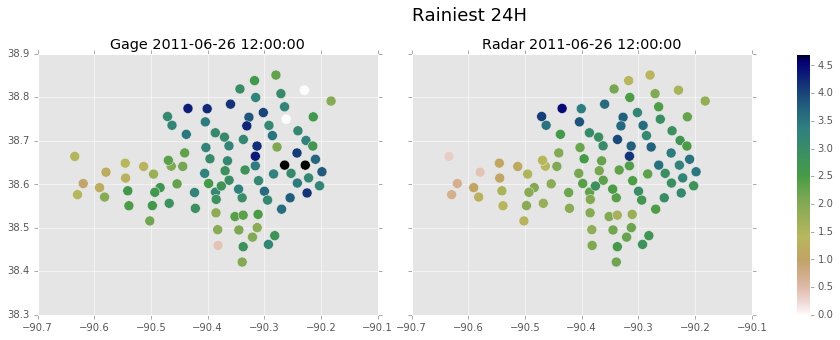

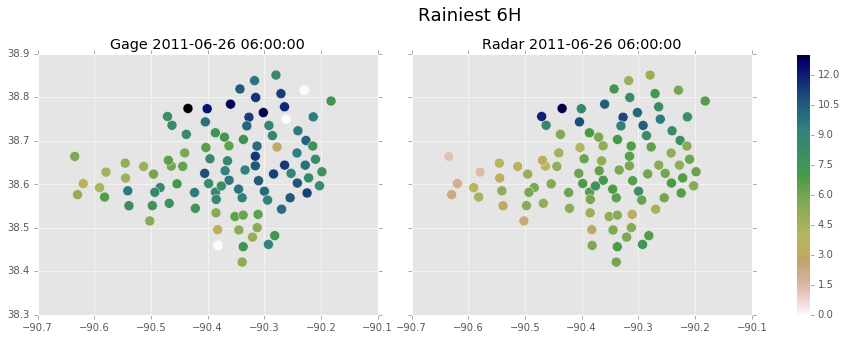

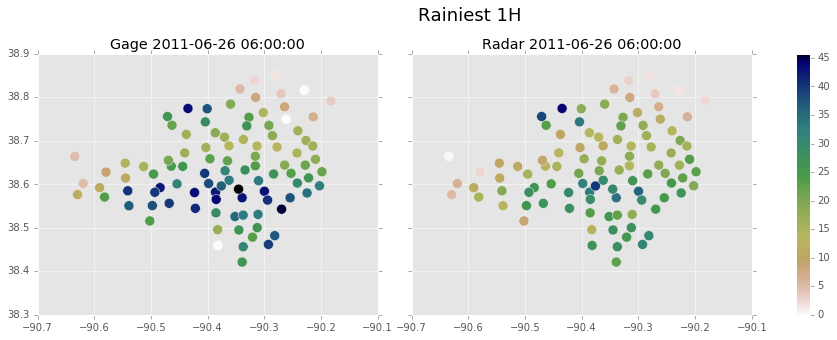

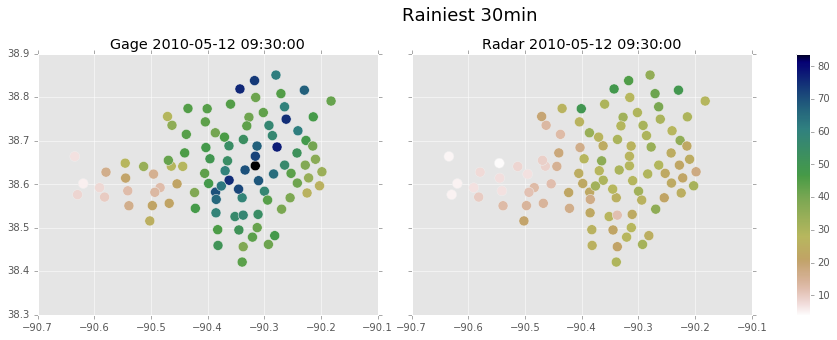

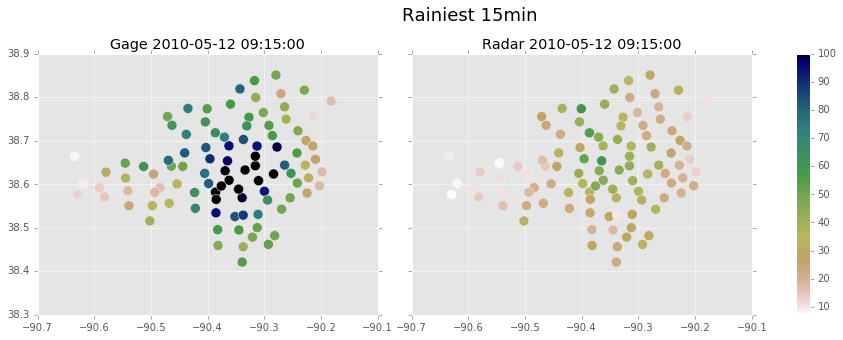

In [34]:
for time_step, base in zip(['24H', '6H','1H','30min', '15min'], [12,0,0,0,0]):
    p.get_rainiest(1, time_step=time_step, base=base)
    map_rain(p.rainiest, title='Rainiest '+time_step, sharec=True, save=False)